# Topic analysis of clothing reviews with embeddingd

In [5]:
import os
import openai
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import chromadb
from scipy.spatial import distance
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

openai_api_key = os.environ["OPENAI_API_KEY"]

EMBEDDING_MODEL = "text-embedding-ada-002"

## Load the dataset

In [6]:
reviews = pd.read_csv("documents/womens_clothing_e-commerce_reviews.csv")
review_texts = reviews["Review Text"].dropna()

## Create and store the embeddings for reviews in one API call

In [7]:
client = openai.OpenAI(api_key=openai_api_key)
responses = client.embeddings.create(input=review_texts.tolist(), model=EMBEDDING_MODEL).model_dump()
embeddings = [response["embedding"] for response in responses["data"]]

## Apply t-SNE for dimensionality reduction

In [8]:
def apply_tsne(embeddings):
    tsne = TSNE(n_components=2, random_state=0)
    return tsne.fit_transform(embeddings)

embeddings_2d = apply_tsne(np.array(embeddings))

## Plotting the results of t-SNE

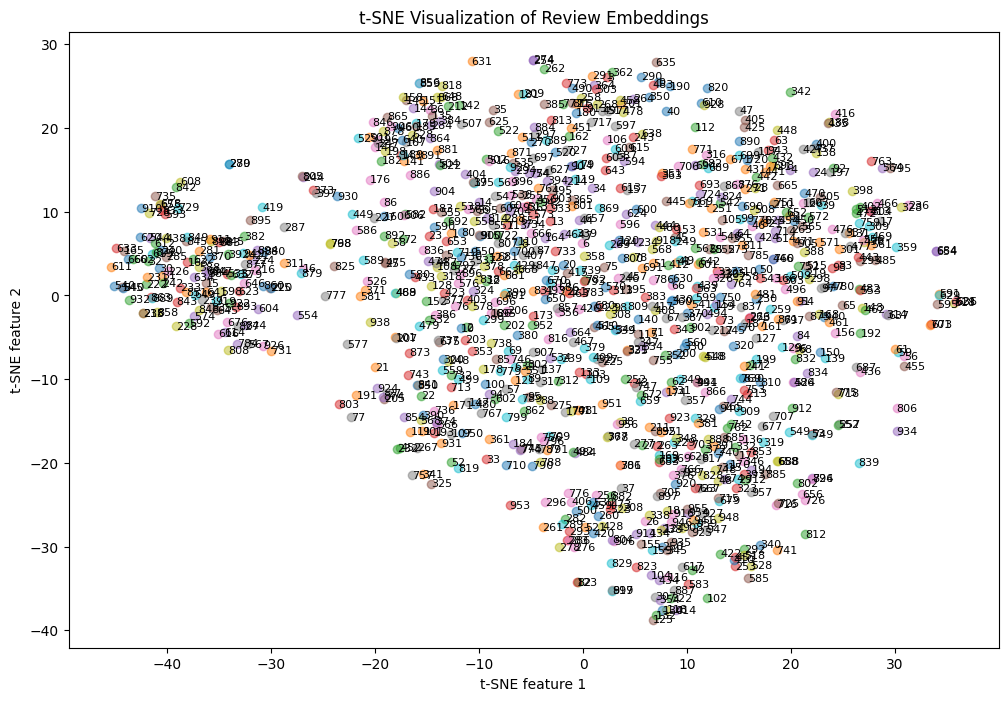

In [9]:
def plot_tsne(tsne_results):
    plt.figure(figsize=(12, 8))
    for i, point in enumerate(tsne_results):
        plt.scatter(point[0], point[1], alpha=0.5)
        plt.text(point[0], point[1], str(i), fontsize=8, verticalalignment='center')
    plt.title("t-SNE Visualization of Review Embeddings")
    plt.xlabel("t-SNE feature 1")
    plt.ylabel("t-SNE feature 2")
    plt.show()

plot_tsne(embeddings_2d)

## Create embeddings

In [10]:
# Define topics
categories = ["Quality", "Fit", "Style", "Comfort"]

# Create embeddings for all categories in one API call
category_responses = client.embeddings.create(input=categories, model=EMBEDDING_MODEL).model_dump()

# Extract embeddings from the responses and map them to their respective categories
category_embeddings = [embedding["embedding"] for embedding in category_responses["data"]]

## Categorize feedback

In [11]:
# Function to categorize feedback
def categorize_feedback(text_embedding, category_embeddings):
    similarities = [{"distance": distance.cosine(text_embedding, cat_emb), "index":i}
                     for i, cat_emb in enumerate(category_embeddings)]
    closest = min(similarities, key=lambda x: x["index"])
    return categories[closest["index"]]

# Categorize feedback
feedback_categories = [categorize_feedback(embedding, category_embeddings) for embedding in embeddings]

## Store embeddings in vector database

In [12]:
# Initialize Chromadb instance for vector storage
client = chromadb.PersistentClient()

# Define vector database
review_embeddings_db = client.create_collection(
    name="review_embeddings",
    embedding_function=OpenAIEmbeddingFunction(api_key=openai_api_key))

# Store embeddings inside vector database
review_embeddings_db.add(
    documents=review_texts.tolist(),
    ids=[str(i) for i in range(len(review_texts))]
)

In [13]:
# Function for similarity search using vector db query function
def find_similar_reviews(input_text, vector_db, n=3):
    collection = client.get_collection(
        name="review_embeddings",
        embedding_function=OpenAIEmbeddingFunction(api_key=openai_api_key))
    results = collection.query(
        query_texts=[input_text],
        n_results=n
    )
    return results

# Example feedback and finding similar feedback
example_review = "Absolutely wonderful - silky and sexy and comfortable"
most_similar_reviews = find_similar_reviews(example_review, review_embeddings_db, 3)["documents"][0]
print(most_similar_reviews)

# Clean up
client.delete_collection(name="review_embeddings")


['Absolutely wonderful - silky and sexy and comfortable', 'Very comfortable and versatile. got lots of compliments.', 'Loved this top. great design. comfortable and unique. soft material']
